In [2]:
import os
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import torchvision
import torchtoolbox
from PIL import Image

# check torch cuda is available

print(torch.cuda.is_available())

# Define settings

In [3]:
# please change architecture settings below
arch_name = 'efficientnet-b4'
batch_size = 16
optimizer_name = "Adam"
lr = 0.0002
num_epoch = 50
from datetime import datetime
time_str_name = str(datetime.now().strftime("%Y%m%d-%H%M"))+'_model.pt'

model_name = os.path.join('../models',time_str_name)

# Define dataset class and transform

In [4]:
# define the class for image similarity network
# employing a Custom Dataset Class
class TripletDataset():
    def __init__(self,dataframe,transform,transform_random):
        self.data = shuffle(dataframe)
        self.transform = transform
        self.transform_random = transform_random
        
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx,0]
        label = self.data.iloc[idx,1]
        positive = self.data[self.data.labels == label]
        negative = self.data[self.data.labels != label]
        postivie = positive.sample(1)
        negative = negative.sample(1)
        positive_name = postivie.iloc[0,0]
        negative_name = negative.iloc[0,0]
        query = Image.open(img_name)
        pos = Image.open(positive_name)
        neg = Image.open(negative_name)
        
        if self.transform is not None:
            query = self.transform(query)
            pos = self.transform_random(pos)
            neg = self.transform_random(neg)
        return query,pos,neg,label
    
    def __len__(self):
        return self.data.shape[0]
            
            

In [5]:
# building transform
from torchvision import transforms, models
from torchtoolbox.transform import RandomGaussianNoise

train_transform = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomResizedCrop(size=64),
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomPerspective(p=1),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
    ]
)
no_transform =transforms.Compose(
    [
        transforms.Resize((64, 64)),
         transforms.ToTensor(),
    ])
random_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomApply([transforms.RandomHorizontalFlip(p=0.5),transforms.RandomPerspective(),transforms.RandomVerticalFlip()]),
    transforms.ToTensor()])

# Define the model architecture

In [6]:
from efficientnet_pytorch import EfficientNet
import math
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = EfficientNet.from_pretrained(arch_name)
num_features = model._fc.in_features
model._fc = nn.Sequential(torch.nn.Linear(num_features,256,bias = True))
model = model.to(DEVICE)
for param in model.parameters():
    param.require_grad = True

Loaded pretrained weights for efficientnet-b4


In [7]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1,beta=0.5, p=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.p=0.2
        self.beta= beta
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        p = self.p
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        distance_pos_neg = self.calc_euclidean(positive, negative)
        distance_postive_reverse = self.calc_euclidean(positive, anchor)
        losses = torch.relu(distance_positive - p*distance_negative + self.margin) + torch.relu(distance_postive_reverse - distance_pos_neg + self.margin)

        return losses.mean()

In [8]:
from torchtoolbox.nn import LabelSmoothingLoss

criterion= TripletLoss(margin=1.0,beta=0.5)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0002)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True,min_lr=0.0000001)


In [16]:
os.getcwd()

'/home/hieu/notebooks'

# Loading in the dataset

In [9]:
# create logging
import logging
file_name = model_name + ".txt"
f = open(os.path.join('../logs', file_name), "w+")
f.close()
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# create console handler and set level to info
handler = logging.StreamHandler()
handler.setLevel(logging.INFO)
formatter = logging.Formatter("%(message)s")
handler.setFormatter(formatter)
handler.terminator = ""
logger.addHandler(handler)

# create error file handler and set level to error
handler = logging.FileHandler('../logs/'+file_name, "w", encoding=None, delay="true")
handler.setLevel(logging.INFO)
formatter = logging.Formatter("%(message)s")
handler.setFormatter(formatter)
handler.terminator = ""
logger.addHandler(handler)

In [10]:
train_data=pd.read_csv('../csv_files/full_data_filtered.csv',usecols=["file_names","labels","sources"])
train_data = train_data[train_data['sources'].isin(['/data1/hold_gun_youtube','/home/hieu/high_qual'])]
print(train_data.labels.value_counts())

train_data = train_data.groupby('labels').apply(lambda x: x.sample(n=951)).reset_index(drop = True)
print(train_data.labels.value_counts())
from sklearn.utils import shuffle
train_set = TripletDataset(train_data,train_transform,random_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size,shuffle = True)


1    4192
0     951
Name: labels, dtype: int64
1    951
0    951
Name: labels, dtype: int64


In [77]:
train_data['sources'].value_counts()

/data1/hold_gun_youtube    1390
/home/hieu/high_qual        512
Name: sources, dtype: int64

# Training on the dataset

In [82]:
from livelossplot import PlotLosses
torch.cuda.empty_cache()
model = model.to(DEVICE)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True,min_lr=0.0000001)
min_loss = 100000
print(len(train_loader.dataset))
log = []
liveloss = PlotLosses()
for epoch in range(0,num_epoch):
    loss_total = 0
    loss_total_cls = 0
    model.train()
    for data in train_loader:
        d = data
        query = d[0].to(DEVICE)
        pos = d[1].to(DEVICE)
        neg = d[2].to(DEVICE)
        label = d[3].to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(query),model(pos),model(neg))
        loss.backward()
        optimizer.step()
        loss_total = (loss_total + loss.item()*batch_size)
        
    scheduler.step(loss_total)
    logging.info("\n Epoch {} / {} , Similarity Loss : {} ".format(epoch+1,num_epoch,loss_total/len(train_loader.dataset)))
    logging.info("Learning rate = {} ".format(optimizer.param_groups[0]['lr']))

    if (loss_total <  min_loss):
        min_loss = (loss_total)
        torch.save(model.state_dict(), model_name)
        print(" => save best epoch due to training loss {}".format(min_loss/len(train_loader.dataset)))
        
    log.extend([min_loss/len(train_loader.dataset)])
#     liveloss.update(log)
#     liveloss.send()

1902



 Epoch 1 / 50 , Similarity Loss : 0.8196947057540485 
 Epoch 1 / 50 , Similarity Loss : 0.8196947057540485 
 Epoch 1 / 50 , Similarity Loss : 0.8196947057540485 
 Epoch 1 / 50 , Similarity Loss : 0.8196947057540485 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 

 => save best epoch due to training loss 0.8196947057540485



 Epoch 2 / 50 , Similarity Loss : 0.6551430715183354 
 Epoch 2 / 50 , Similarity Loss : 0.6551430715183354 
 Epoch 2 / 50 , Similarity Loss : 0.6551430715183354 
 Epoch 2 / 50 , Similarity Loss : 0.6551430715183354 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 

 => save best epoch due to training loss 0.6551430715183354



 Epoch 3 / 50 , Similarity Loss : 0.6862332165303917 
 Epoch 3 / 50 , Similarity Loss : 0.6862332165303917 
 Epoch 3 / 50 , Similarity Loss : 0.6862332165303917 
 Epoch 3 / 50 , Similarity Loss : 0.6862332165303917 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 
 Epoch 4 / 50 , Similarity Loss : 0.5885542839546184 
 Epoch 4 / 50 , Similarity Loss : 0.5885542839546184 
 Epoch 4 / 50 , Similarity Loss : 0.5885542839546184 
 Epoch 4 / 50 , Similarity Loss : 0.5885542839546184 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 

 => save best epoch due to training loss 0.5885542839546184



 Epoch 5 / 50 , Similarity Loss : 0.5708655804301662 
 Epoch 5 / 50 , Similarity Loss : 0.5708655804301662 
 Epoch 5 / 50 , Similarity Loss : 0.5708655804301662 
 Epoch 5 / 50 , Similarity Loss : 0.5708655804301662 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 

 => save best epoch due to training loss 0.5708655804301662



 Epoch 6 / 50 , Similarity Loss : 0.5292383013087493 
 Epoch 6 / 50 , Similarity Loss : 0.5292383013087493 
 Epoch 6 / 50 , Similarity Loss : 0.5292383013087493 
 Epoch 6 / 50 , Similarity Loss : 0.5292383013087493 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 

 => save best epoch due to training loss 0.5292383013087493



 Epoch 7 / 50 , Similarity Loss : 0.4911677048284047 
 Epoch 7 / 50 , Similarity Loss : 0.4911677048284047 
 Epoch 7 / 50 , Similarity Loss : 0.4911677048284047 
 Epoch 7 / 50 , Similarity Loss : 0.4911677048284047 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 

 => save best epoch due to training loss 0.4911677048284047



 Epoch 8 / 50 , Similarity Loss : 0.5234432507200572 
 Epoch 8 / 50 , Similarity Loss : 0.5234432507200572 
 Epoch 8 / 50 , Similarity Loss : 0.5234432507200572 
 Epoch 8 / 50 , Similarity Loss : 0.5234432507200572 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 
 Epoch 9 / 50 , Similarity Loss : 0.5072363100781425 
 Epoch 9 / 50 , Similarity Loss : 0.5072363100781425 
 Epoch 9 / 50 , Similarity Loss : 0.5072363100781425 
 Epoch 9 / 50 , Similarity Loss : 0.5072363100781425 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 
 Epoch 10 / 50 , Similarity Loss : 0.4028790636080171 
 Epoch 10 / 50 , Similarity Loss : 0.4028790636080171 
 Epoch 10 / 50 , Similarity Loss : 0.4028790636080171 
 Epoch 10 / 50 , Similarity Loss : 0.4028790636080171 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 

 => save best epoch due to training loss 0.4028790636080171



 Epoch 11 / 50 , Similarity Loss : 0.43654710571472577 
 Epoch 11 / 50 , Similarity Loss : 0.43654710571472577 
 Epoch 11 / 50 , Similarity Loss : 0.43654710571472577 
 Epoch 11 / 50 , Similarity Loss : 0.43654710571472577 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 Learning rate = 0.0002 

KeyboardInterrupt: 

# Generate training data for Classification Learning

In [11]:
# reloading the model in the eval mode
model = model.to(DEVICE)
model.load_state_dict(torch.load('../models/20200630-1025_model.pt'))

model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [18]:
!nvidia-smi

Wed Jul  1 10:03:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0 Off |                  N/A |
| 49%   55C    P5    14W / 180W |    701MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [19]:
# plotting a k nearest neighbor using sklearn
# convert the learned features to numpy arrays
model= model.to(DEVICE)
features = np.empty((256,))
labels = []
for i,data in enumerate(train_loader):

    samples = data[0].to(DEVICE)
    label = data[3].to(DEVICE)
    features = np.vstack((features,model(samples).cpu().detach().numpy()))
    labels.extend(label.tolist())

labels = np.array(labels)
print(features.shape)
print(labels.shape)

(1903, 256)
(1902,)


In [20]:
features_df = pd.DataFrame(data=features[1:,:]    # values

                          )
print(features_df.shape)
print(features_df.head(4))
import sklearn
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
scaler = sklearn.preprocessing.MinMaxScaler()
features_data=pd.DataFrame(scaler.fit_transform(features_df))
train_points = features_data.copy()
train_points['label'] = labels
train_points.to_csv(model_name+'train_points.csv')
# fit to the knn model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
clf1 = KNeighborsClassifier(3)
labels = pd.DataFrame(labels)
# neigh = VotingClassifier(estimators=[('knn', clf1), ('gnb', clf2)],voting='hard')
clf1.fit(features_data, labels)

(1902, 256)
        0         1         2         3         4         5         6    \
0 -0.095999  0.049172 -0.009183 -0.015939  0.090810  0.036629 -0.150306   
1 -0.123820  0.062414 -0.008314 -0.017740  0.108344  0.042550 -0.176775   
2  0.113689 -0.059559 -0.032276 -0.006975 -0.098126 -0.013583  0.076281   
3 -0.107438  0.051672 -0.009861 -0.016005  0.097750  0.038085 -0.160540   

        7         8         9    ...       246       247       248       249  \
0  0.025182  0.024965  0.040963  ... -0.034861  0.078955  0.044701  0.034445   
1  0.031382  0.021959  0.048678  ... -0.043658  0.094453  0.053028  0.046341   
2 -0.006824  0.034024 -0.044886  ...  0.047861 -0.036896 -0.033450 -0.057313   
3  0.026904  0.023728  0.041977  ... -0.035861  0.083344  0.047712  0.037116   

        250       251       252       253       254       255  
0  0.110727 -0.067206 -0.190206 -0.119013  0.020273 -0.132203  
1  0.139846 -0.074684 -0.232696 -0.136537  0.023385 -0.160086  
2 -0.121550  0.0176

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


KNeighborsClassifier(n_neighbors=3)

# Predict on test set

In [21]:
class ClassificationDataset:
    def __init__(self, data, data_path, transform, training=True):
        """Define the dataset for classification problems

        Args:
            data ([dataframe]): [a dataframe that contain 2 columns: image name and label]
            data_path ([str]): [path/to/folder that contains image file]
            transform : [augmentation methods and transformation of images]
            training (bool, optional): []. Defaults to True.
        """
        self.data = data
        self.imgs = data["file_name"].unique().tolist()
        self.data_path = data_path
        self.training = training
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.data_path, self.data.iloc[idx, 0]))
        label = self.data.iloc[idx, 1]

        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.imgs)

In [22]:
# get test true labels and features
def get_test_features(model,test_loader,DEVICE):
    model.eval()
    model = model.to(DEVICE)
    test_features = np.empty((256,))
    test_labels = []
    for data,label in test_loader:
        data = data.to(DEVICE)
        label = label.to(DEVICE)
        outputs = model(data)
        test_features = np.vstack((test_features,outputs.cpu().detach().numpy()))
        test_labels.extend(label)
    test_labels = np.array(test_labels)   
    print(test_features.shape)
    print(test_labels.shape)
    test_features_df = pd.DataFrame(data =test_features[1:,:])
    return test_features_df,test_labels


In [1]:
print(model_name)

NameError: name 'model_name' is not defined

In [24]:
os.getcwd()

'/home/hieu/notebooks'

(123, 2)
123
(124, 256)
(123,)
              precision    recall  f1-score   support

      nohold       0.95      0.71      0.81        97
        hold       0.44      0.85      0.58        26

    accuracy                           0.74       123
   macro avg       0.69      0.78      0.70       123
weighted avg       0.84      0.74      0.76       123



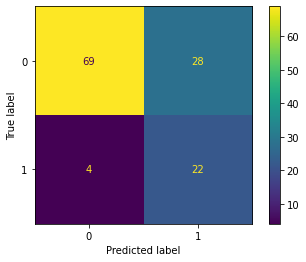

In [26]:
# test on TA data test - classification dataset
test_lowres_data=pd.read_csv('../bhxanh/test.csv',usecols=["file_name","label"])
test_lowres_data.file_name = test_lowres_data.file_name.str.replace("\\","/")
# test_lowres_data['label'] = test_lowres_data['label'].map({'hold':1,'nohold':0})
print(test_lowres_data.shape)
test_lowres= ClassificationDataset(test_lowres_data,"..",no_transform)
test_loader2 = torch.utils.data.DataLoader(test_lowres,batch_size=8,shuffle=False)
print(len(test_loader2.dataset))
low_res_features , low_res_labels = get_test_features(model,test_loader2,"cpu")
test_points = low_res_features.copy()
test_points['label'] = low_res_labels
test_points.to_csv(model_name+'test_points_bhx_set.csv')
low_res_features=scaler.transform(low_res_features)
low_preds = clf1.predict(low_res_features)
print(sklearn.metrics.classification_report(low_res_labels,low_preds,target_names=['nohold','hold']))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf1, low_res_features, low_res_labels)

(48, 2)
48
(49, 256)
(48,)
              precision    recall  f1-score   support

      nohold       0.81      1.00      0.89        21
        hold       1.00      0.81      0.90        27

    accuracy                           0.90        48
   macro avg       0.90      0.91      0.90        48
weighted avg       0.92      0.90      0.90        48



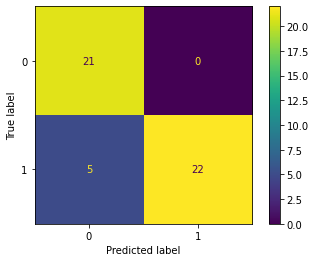

In [23]:
# test on TA data test - classification dataset
test_lowres_data=pd.read_csv('../fail_set/fail_case.csv',usecols=["file_name","label"])
test_lowres_data.file_name = test_lowres_data.file_name.str.replace("\\","/")
# test_lowres_data['label'] = test_lowres_data['label'].map({'hold':1,'nohold':0})
print(test_lowres_data.shape)
test_lowres= ClassificationDataset(test_lowres_data,"..",no_transform)
test_loader2 = torch.utils.data.DataLoader(test_lowres,batch_size=8,shuffle=False)
print(len(test_loader2.dataset))
low_res_features , low_res_labels = get_test_features(model,test_loader2,"cpu")
test_points = low_res_features.copy()
test_points['label'] = low_res_labels
test_points.to_csv(model_name+'test_points_ta_set.csv')
low_res_features=scaler.transform(low_res_features)
low_preds = clf1.predict(low_res_features)
print(sklearn.metrics.classification_report(low_res_labels,low_preds,target_names=['nohold','hold']))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf1, low_res_features, low_res_labels)

(430, 2)
430
(431, 256)
(430,)
              precision    recall  f1-score   support

      nohold       0.96      0.88      0.92       327
        hold       0.69      0.88      0.78       103

    accuracy                           0.88       430
   macro avg       0.83      0.88      0.85       430
weighted avg       0.90      0.88      0.88       430



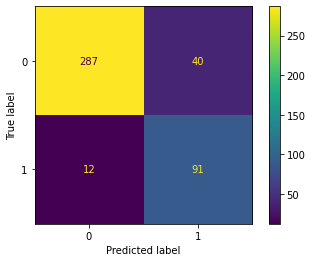

In [86]:
# test on test - classification dataset
test_lowres_data=pd.read_csv('test.csv',usecols=["file_name","label"])
test_lowres_data['label'] = test_lowres_data['label'].map({'hold':1,'nohold':0})
print(test_lowres_data.shape)
test_lowres= ClassificationDataset(test_lowres_data,'../test_data',no_transform)
test_loader2 = torch.utils.data.DataLoader(test_lowres,batch_size=8,shuffle=False)
print(len(test_loader2.dataset))
low_res_features , low_res_labels = get_test_features(model,test_loader2,"cpu")
test_points = low_res_features.copy()
test_points['label'] = low_res_labels
test_points.to_csv(model_name+'test_points.csv')
low_res_features=scaler.transform(low_res_features)
low_preds = clf1.predict(low_res_features)
print(sklearn.metrics.classification_report(low_res_labels,low_preds,target_names=['nohold','hold']))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf1, low_res_features, low_res_labels)